In [1]:
# basic packages
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn

#Shared/Utility scripts
import sys
sys.path.insert(0, '../..') #sys allows for the .ipynb file to connect to the shared folder files
from shared_scripts import Simple_Eval, dataloader, mlp_dataprocessing, mlp_model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HOME = os.path.expanduser('~')


modelname = 'MLP'
model_path = f"{HOME}/NWM_ML/Model/{modelname}"
print(f"{modelname} development script")

Device: cuda
Device: cuda
MLP development script


In [2]:
modelname = 'MLP'
model_path = f"{HOME}/NWM_ML/Model/{modelname}"

cfsday_AFday = 1.983

#input columns
input_columns =[
                'Lat', 
                'Long', 
                'Drainage_area_mi2', 
                'Mean_Basin_Elev_ft',       
                'Perc_Forest', 
                'Perc_Develop', 
                'Perc_Imperv', 
                'Perc_Herbace',       
                'Perc_Slop_30', 
                'Mean_Ann_Precip_in', 
                's1',       
                's2', 
                'storage', 
                'swe', 
                'NWM_flow', 
                'DOY', 
                'tempe(F)', 
                'precip(mm)'
                ]

target = 'flow_cfs'

test_years = [2019, 2020]                 

#load data
datapath = f"{HOME}/NWM_ML/Data/input"
trainingfile = "final_input.parquet"

df, StreamStats = dataloader.get_ML_Data(datapath, trainingfile)
df.head()

df needs no processing


,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,...,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY,tempe(F),precip(mm)
0,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-28,78.55521,-0.891007,-0.453991,0.0,1.2,55.0,301,39.239582,0.0
1,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-29,98.61146,-0.891007,-0.453991,0.0,1.2,55.0,302,45.068712,0.0
2,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-30,97.60208,-0.891007,-0.453991,0.0,1.1,54.0,303,50.945891,0.0
3,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-31,99.33125,-0.891007,-0.453991,0.0,1.2,54.0,304,45.480097,0.0
4,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-11-01,95.76354,-0.998630,0.052336,0.0,1.2,54.0,305,46.656777,0.0


### Dataprocessing
* Editing the features based on the feature importance
* Remove headwater stations from dataset
* make sure dates are in datetime format

In [3]:
#get non headwater stations
headwater_stations = ['10011500', # Bear River headwaters before WY state line
                      '10109000', # Logan River above dams
                      '10113500', # HW Blacksmith fork
                      '10128500', # Upper Weber above Oakley
                      '10131000', #Chalk creek before Weber - lots of upstream irrigation, potentially include
                        '10146400', #Currant Creek above Mona Reservoir - lots of upstream irrigation, potentially include
                        '10150500', #Spanish fork after diamond fork - potentially include because of 6th water diversion CUP
                        '10154200', #Upper Provo river after confluence of N/S forks - potentially include because of duchense tunnel water diversion CUP
                        '10172700', #Vernon creek 2 ranges west of Utah Lake, shouldnt be included because not in GSL basin 
                        '10172800', #Willow creek west of Gransville,  shouldnt be included because does not make it to GSL
                          '10172952'
                          ] #Dunn creek in Raft River Range, shouldnt be included because drains to bonnevile salt flats 

#remove headwater stations
df = df[~df['station_id'].isin(headwater_stations)]

#get stations with correct swe and storage features
#The following sites have swe 

'''
['10011500', '10105900', '10109000', '10126000', '10131000',
       '10133650', '10133800', '10133980', '10134500', '10136500',
       '10140700', '10141000', '10150500', '10154200', '10155000',
       '10155200']
'''

#the following sites have swe and storage
'''
['10126000', '10134500', '10136500', '10140700', '10141000',
       '10155200']
'''

stations = df['station_id'][(df['swe']>0) & (df['storage']>0)].unique()

#Train model with these stations
df = df[df['station_id'].isin(stations)]

#convert dates to datetime format
df.datetime = pd.to_datetime(df.datetime)

# #reset index to clean up df
df.reset_index( inplace =  True, drop = True)

#fit a scaler,save, and scale the training data
x_train_scaled, y_scaled_train = mlp_dataprocessing.mlp_scaler(
                                                      df,
                                                      test_years, 
                                                      target, 
                                                      input_columns, 
                                                      model_path, 
                                                      scalertype = 'MinMax'
                                                      )

x_test_scaled, y_test_temp, x_test_temp, station_index_list = mlp_dataprocessing.mlp_testscaler(
                                                      df,
                                                      test_years, 
                                                      target, 
                                                      input_columns, 
                                                      model_path, 
                                                      )

# Convert to tensor for PyTorch
x_train_scaled_t = torch.Tensor(x_train_scaled)
y_train_scaled_t = torch.Tensor(y_scaled_train)
#Make sure the tensors on are the respective device (cpu/gpu)
x_train_scaled_t = x_train_scaled_t.to(device)
y_train_scaled_t = y_train_scaled_t.to(device)

(26089, 1)
(26089, 18)
(3834, 18)


### Set up Testing year
* Select year(s) not used in training
* Convert to numpy array
* Load scaler and scale data

## Train the model

* randomize training data..
* add training loss https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

## Loss functions

### Mean Absolute Error (MAE)
Regression problems, especially when the distribution of the target variable has outliers, such as small or big values that are a great distance from the mean value.
It is considered to be more robust to outliers.
PyTorch implementation as **nn.L1Loss()**

### Mean Squared Error (MSE)
The MSE, also called L2 Loss, computes the average of the squared differences between actual values and predicted values.
Pytorch MSE Loss always outputs a positive result, regardless of the sign of actual and predicted values. 
To enhance the accuracy of the model, you should try to reduce the L2 Loss—a perfect value is 0.0. 

The squaring implies that larger mistakes produce even larger errors than smaller ones. 
If the classifier is off by 100, the error is 10,000. If it’s off by 0.1, the error is 0.01. This punishes the model for making big mistakes and encourages small mistakes. 

MSE is the default loss function for most Pytorch regression problems.

### Make your own loss function
https://neptune.ai/blog/pytorch-loss-functions

In [16]:
epochs = [60] # - seems to converge around 80 epochs with 100 batrch size
batch_size = [60]
learning_rate = [0.0001]  #look up learning rate scheduler https://www.geeksforgeeks.org/understanding-pytorch-learning-rate-scheduling/ -  smaller learning rates doing better!
decay = [0.0005]
L1 = [30, 60, 90]
L2 = [30, 60, 90]
L3 = [30, 60, 90]
L4 = [30, 90]
L5 = [30, 90]
L6 = [10, 30]

search_params = epochs, batch_size, learning_rate, decay, L1, L2, L3, L4, L5, L6
loss_func = nn.MSELoss()
supply = False


GS_Eval_DF, GS_Eval_dict = mlp_model.mlp_optimization(search_params, 
                     x_train_scaled_t, 
                     y_train_scaled_t, 
                     loss_func, 
                     model_path, 
                     modelname, 
                     supply, 
                     test_years, 
                     stations,                                                               
                     x_test_temp,
                     x_test_scaled, 
                     y_test_temp,
                     StreamStats,
                     station_index_list)
GS_Eval_DF

Optimizing the MLP model by evaluating 216 models using grid search validation
Training 1 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 30, 30, 30, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 56.033262729644775 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.44,236.0,247.0,221.61,192.77,-30.30,-17.07
10136500,-0.42,0.39,644.0,374.0,330.76,190.80,-137.08,-51.57
10155200,0.63,0.28,192.0,245.0,29.28,73.06,15.23,-13.70
10141000,-2.10,0.22,1169.0,420.0,1111.22,301.99,-304.72,-74.88
10126000,-0.31,0.18,1716.0,1162.0,306.30,203.98,-39.65,-55.85
10134500,-0.97,0.11,132.0,62.0,545.15,298.79,-173.33,-84.69


Training 2 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 30, 30, 30, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 55.87562561035156 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.56,132.0,40.0,545.15,159.07,-173.33,-31.75
10140700,0.29,0.51,236.0,245.0,221.61,162.41,-30.30,-8.22
10136500,-0.42,0.40,644.0,379.0,330.76,182.78,-137.08,-52.55
10155200,0.63,0.37,192.0,231.0,29.28,56.24,15.23,-3.03
10141000,-2.10,0.25,1169.0,426.0,1111.22,270.92,-304.72,-71.00
10126000,-0.31,0.21,1716.0,1153.0,306.30,196.70,-39.65,-55.35


Training 3 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 30, 30, 90, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 54.46203279495239 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.60,132.0,35.0,545.15,129.43,-173.33,-6.97
10136500,-0.42,0.60,644.0,290.0,330.76,124.31,-137.08,-32.54
10141000,-2.10,0.49,1169.0,345.0,1111.22,211.62,-304.72,-47.97
10140700,0.29,0.37,236.0,235.0,221.61,118.54,-30.30,17.11
10155200,0.63,0.31,192.0,237.0,29.28,35.80,15.23,15.92
10126000,-0.31,0.28,1716.0,1031.0,306.30,172.55,-39.65,-42.62


Training 4 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 30, 30, 90, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 57.650217056274414 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.59,132.0,36.0,545.15,140.72,-173.33,-17.65
10140700,0.29,0.54,236.0,232.0,221.61,146.75,-30.30,1.50
10155200,0.63,0.41,192.0,225.0,29.28,52.96,15.23,-2.26
10136500,-0.42,0.34,644.0,375.0,330.76,179.20,-137.08,-62.19
10126000,-0.31,0.20,1716.0,1172.0,306.30,201.60,-39.65,-57.42
10141000,-2.10,0.18,1169.0,429.0,1111.22,281.92,-304.72,-78.83


Training 5 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 30, 90, 30, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 56.390201807022095 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.67,132.0,36.0,545.15,127.37,-173.33,-14.29
10140700,0.29,0.52,236.0,243.0,221.61,145.79,-30.30,-1.14
10136500,-0.42,0.39,644.0,372.0,330.76,177.74,-137.08,-54.47
10155200,0.63,0.35,192.0,232.0,29.28,48.09,15.23,6.25
10141000,-2.10,0.21,1169.0,431.0,1111.22,281.49,-304.72,-76.12
10126000,-0.31,0.18,1716.0,1202.0,306.30,206.55,-39.65,-60.21


Training 6 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 30, 90, 30, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 58.47458744049072 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.58,132.0,38.0,545.15,150.30,-173.33,-22.56
10140700,0.29,0.53,236.0,233.0,221.61,151.55,-30.30,-1.63
10155200,0.63,0.40,192.0,226.0,29.28,53.42,15.23,-2.41
10136500,-0.42,0.38,644.0,372.0,330.76,178.83,-137.08,-56.86
10141000,-2.10,0.24,1169.0,421.0,1111.22,281.57,-304.72,-73.22
10126000,-0.31,0.16,1716.0,1197.0,306.30,211.56,-39.65,-59.89


Training 7 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 30, 90, 90, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 58.69123959541321 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.50,236.0,252.0,221.61,185.34,-30.30,-16.20
10134500,-0.97,0.45,132.0,45.0,545.15,205.23,-173.33,-43.59
10155200,0.63,0.40,192.0,229.0,29.28,64.45,15.23,-11.01
10136500,-0.42,0.24,644.0,421.0,330.76,207.99,-137.08,-70.35
10126000,-0.31,0.11,1716.0,1275.0,306.30,226.07,-39.65,-68.25
10141000,-2.10,0.08,1169.0,468.0,1111.22,311.25,-304.72,-88.60


Training 8 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 30, 90, 90, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 54.61199712753296 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.59,132.0,35.0,545.15,117.62,-173.33,0.35
10140700,0.29,0.54,236.0,235.0,221.61,144.19,-30.30,4.12
10155200,0.63,0.39,192.0,226.0,29.28,44.95,15.23,6.10
10136500,-0.42,0.35,644.0,381.0,330.76,177.91,-137.08,-59.51
10141000,-2.10,0.22,1169.0,432.0,1111.22,283.54,-304.72,-74.14
10126000,-0.31,0.16,1716.0,1221.0,306.30,211.17,-39.65,-62.10


Training 9 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 60, 30, 30, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 50.212810039520264 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.68,132.0,34.0,545.15,114.28,-173.33,-14.15
10140700,0.29,0.51,236.0,249.0,221.61,153.58,-30.30,-4.55
10136500,-0.42,0.37,644.0,387.0,330.76,180.55,-137.08,-55.48
10155200,0.63,0.36,192.0,233.0,29.28,56.99,15.23,-1.91
10141000,-2.10,0.20,1169.0,442.0,1111.22,278.80,-304.72,-76.16
10126000,-0.31,0.12,1716.0,1274.0,306.30,222.82,-39.65,-67.62


Training 10 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 60, 30, 30, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 51.60487246513367 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10126000,-0.31,NaN,1716.0,1432.0,306.30,70.27,-39.65,79.86
10134500,-0.97,NaN,132.0,215.0,545.15,1312.60,-173.33,-343.73
10136500,-0.42,NaN,644.0,432.0,330.76,137.62,-137.08,32.02
10140700,0.29,NaN,236.0,283.0,221.61,332.75,-30.30,-33.18
10141000,-2.10,NaN,1169.0,518.0,1111.22,196.78,-304.72,19.12
10155200,0.63,NaN,192.0,302.0,29.28,73.86,15.23,6.58


Training 11 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 60, 30, 90, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.553252935409546 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.57,132.0,39.0,545.15,160.99,-173.33,-35.56
10140700,0.29,0.49,236.0,246.0,221.61,158.59,-30.30,-7.02
10136500,-0.42,0.44,644.0,356.0,330.76,172.30,-137.08,-47.52
10155200,0.63,0.31,192.0,240.0,29.28,58.78,15.23,-1.28
10141000,-2.10,0.24,1169.0,418.0,1111.22,287.70,-304.72,-73.06
10126000,-0.31,0.20,1716.0,1158.0,306.30,198.84,-39.65,-55.36


Training 12 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 60, 30, 90, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 51.76394081115723 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.52,236.0,253.0,221.61,185.90,-30.30,-19.50
10134500,-0.97,0.43,132.0,47.0,545.15,212.51,-173.33,-41.59
10155200,0.63,0.42,192.0,225.0,29.28,61.53,15.23,-9.11
10136500,-0.42,0.21,644.0,431.0,330.76,211.35,-137.08,-74.31
10126000,-0.31,0.12,1716.0,1293.0,306.30,223.94,-39.65,-69.89
10141000,-2.10,0.02,1169.0,486.0,1111.22,326.31,-304.72,-93.96


Training 13 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 60, 90, 30, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 51.458553075790405 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.54,132.0,43.0,545.15,179.54,-173.33,-32.19
10140700,0.29,0.49,236.0,258.0,221.61,191.30,-30.30,-19.31
10155200,0.63,0.35,192.0,237.0,29.28,65.34,15.23,-7.96
10136500,-0.42,0.29,644.0,416.0,330.76,215.39,-137.08,-63.52
10126000,-0.31,0.15,1716.0,1227.0,306.30,213.27,-39.65,-62.78
10141000,-2.10,0.08,1169.0,467.0,1111.22,321.13,-304.72,-88.45


Training 14 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 60, 90, 30, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 57.27808094024658 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.54,132.0,36.0,545.15,128.18,-173.33,-1.89
10140700,0.29,0.50,236.0,236.0,221.61,125.77,-30.30,10.89
10136500,-0.42,0.44,644.0,351.0,330.76,156.01,-137.08,-51.10
10155200,0.63,0.38,192.0,226.0,29.28,40.57,15.23,10.28
10141000,-2.10,0.33,1169.0,397.0,1111.22,239.46,-304.72,-63.64
10126000,-0.31,0.25,1716.0,1128.0,306.30,186.62,-39.65,-53.25


Training 15 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 60, 90, 90, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 55.516812801361084 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.51,236.0,243.0,221.61,178.82,-30.30,-15.08
10134500,-0.97,0.39,132.0,48.0,545.15,217.70,-173.33,-53.86
10155200,0.63,0.39,192.0,230.0,29.28,66.44,15.23,-11.86
10136500,-0.42,0.29,644.0,395.0,330.76,198.63,-137.08,-66.48
10126000,-0.31,0.17,1716.0,1209.0,306.30,209.19,-39.65,-61.11
10141000,-2.10,0.10,1169.0,452.0,1111.22,314.37,-304.72,-86.92


Training 16 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 60, 90, 90, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 52.027677059173584 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.50,132.0,38.0,545.15,128.10,-173.33,2.25
10140700,0.29,0.50,236.0,230.0,221.61,125.28,-30.30,11.23
10136500,-0.42,0.45,644.0,337.0,330.76,153.29,-137.08,-50.72
10141000,-2.10,0.38,1169.0,381.0,1111.22,245.20,-304.72,-58.91
10155200,0.63,0.38,192.0,227.0,29.28,43.53,15.23,9.14
10126000,-0.31,0.28,1716.0,1046.0,306.30,175.81,-39.65,-44.83


Training 17 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 90, 30, 30, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 50.40380620956421 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.65,132.0,35.0,545.15,132.41,-173.33,-17.78
10140700,0.29,0.52,236.0,241.0,221.61,148.27,-30.30,-0.63
10155200,0.63,0.38,192.0,228.0,29.28,52.25,15.23,1.95
10136500,-0.42,0.35,644.0,382.0,330.76,183.41,-137.08,-59.27
10141000,-2.10,0.19,1169.0,433.0,1111.22,281.44,-304.72,-77.80
10126000,-0.31,0.16,1716.0,1215.0,306.30,212.41,-39.65,-61.59


Training 18 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 90, 30, 30, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 57.729013204574585 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.54,132.0,39.0,545.15,164.87,-173.33,-25.51
10140700,0.29,0.54,236.0,236.0,221.61,150.96,-30.30,-4.20
10155200,0.63,0.41,192.0,224.0,29.28,56.24,15.23,-4.32
10136500,-0.42,0.36,644.0,377.0,330.76,181.66,-137.08,-58.97
10141000,-2.10,0.22,1169.0,428.0,1111.22,281.55,-304.72,-74.71
10126000,-0.31,0.18,1716.0,1185.0,306.30,205.54,-39.65,-59.07


Training 19 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 90, 30, 90, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.36128807067871 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.68,132.0,35.0,545.15,130.08,-173.33,-15.53
10136500,-0.42,0.49,644.0,345.0,330.76,160.04,-137.08,-40.79
10140700,0.29,0.47,236.0,241.0,221.61,144.62,-30.30,1.78
10141000,-2.10,0.34,1169.0,393.0,1111.22,260.50,-304.72,-61.77
10155200,0.63,0.31,192.0,240.0,29.28,53.54,15.23,4.66
10126000,-0.31,0.19,1716.0,1142.0,306.30,199.82,-39.65,-53.67


Training 20 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 90, 30, 90, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.344271421432495 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.50,236.0,242.0,221.61,189.04,-30.30,-15.32
10155200,0.63,0.38,192.0,227.0,29.28,55.53,15.23,-4.97
10136500,-0.42,0.35,644.0,374.0,330.76,187.49,-137.08,-60.75
10134500,-0.97,0.26,132.0,51.0,545.15,278.99,-173.33,-62.69
10126000,-0.31,0.23,1716.0,1122.0,306.30,191.21,-39.65,-52.99
10141000,-2.10,0.19,1169.0,427.0,1111.22,284.40,-304.72,-78.48


Training 21 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 90, 90, 30, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.98469305038452 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.53,132.0,42.0,545.15,181.57,-173.33,-37.31
10140700,0.29,0.46,236.0,252.0,221.61,174.99,-30.30,-7.95
10136500,-0.42,0.39,644.0,379.0,330.76,191.14,-137.08,-51.36
10155200,0.63,0.29,192.0,245.0,29.28,67.42,15.23,-6.20
10141000,-2.10,0.21,1169.0,428.0,1111.22,300.29,-304.72,-75.93
10126000,-0.31,0.16,1716.0,1190.0,306.30,210.39,-39.65,-58.87


Training 22 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 90, 90, 30, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.47763395309448 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.66,132.0,35.0,545.15,104.16,-173.33,3.47
10140700,0.29,0.54,236.0,235.0,221.61,138.16,-30.30,4.34
10155200,0.63,0.39,192.0,226.0,29.28,45.15,15.23,7.62
10136500,-0.42,0.34,644.0,375.0,330.76,171.47,-137.08,-61.52
10126000,-0.31,0.19,1716.0,1201.0,306.30,204.31,-39.65,-59.63
10141000,-2.10,0.19,1169.0,427.0,1111.22,281.18,-304.72,-77.62


Training 23 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 90, 90, 90, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.442265033721924 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10126000,-0.31,NaN,1716.0,1433.0,306.30,70.26,-39.65,79.95
10134500,-0.97,NaN,132.0,214.0,545.15,1306.48,-173.33,-341.81
10136500,-0.42,NaN,644.0,432.0,330.76,137.12,-137.08,32.32
10140700,0.29,NaN,236.0,283.0,221.61,330.99,-30.30,-32.61
10141000,-2.10,NaN,1169.0,518.0,1111.22,195.74,-304.72,19.47
10155200,0.63,NaN,192.0,302.0,29.28,73.32,15.23,6.98


Training 24 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 30, 90, 90, 90, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.53784441947937 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.52,236.0,230.0,221.61,143.21,-30.30,5.85
10134500,-0.97,0.48,132.0,39.0,545.15,146.91,-173.33,-4.32
10136500,-0.42,0.47,644.0,335.0,330.76,160.60,-137.08,-47.18
10141000,-2.10,0.36,1169.0,384.0,1111.22,249.09,-304.72,-60.42
10155200,0.63,0.35,192.0,231.0,29.28,41.50,15.23,10.41
10126000,-0.31,0.28,1716.0,1031.0,306.30,173.16,-39.65,-42.57


Training 25 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 30, 30, 30, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.44547915458679 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.67,132.0,36.0,545.15,125.24,-173.33,-17.23
10140700,0.29,0.53,236.0,244.0,221.61,149.87,-30.30,-2.65
10155200,0.63,0.39,192.0,229.0,29.28,57.34,15.23,-2.44
10136500,-0.42,0.31,644.0,398.0,330.76,188.37,-137.08,-64.01
10141000,-2.10,0.17,1169.0,441.0,1111.22,278.29,-304.72,-79.56
10126000,-0.31,0.12,1716.0,1268.0,306.30,223.21,-39.65,-67.31


Training 26 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 30, 30, 30, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.294827938079834 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10136500,-0.42,0.62,644.0,299.0,330.76,111.18,-137.08,-31.83
10141000,-2.10,0.56,1169.0,345.0,1111.22,203.01,-304.72,-39.43
10140700,0.29,0.37,236.0,235.0,221.61,95.84,-30.30,32.37
10155200,0.63,0.32,192.0,237.0,29.28,40.28,15.23,27.32
10134500,-0.97,0.27,132.0,46.0,545.15,82.65,-173.33,45.11
10126000,-0.31,0.26,1716.0,1062.0,306.30,178.85,-39.65,-45.52


Training 27 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 30, 30, 90, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 55.87185764312744 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.63,132.0,37.0,545.15,144.52,-173.33,-25.35
10140700,0.29,0.52,236.0,238.0,221.61,144.24,-30.30,-2.12
10136500,-0.42,0.45,644.0,355.0,330.76,167.63,-137.08,-48.53
10155200,0.63,0.37,192.0,229.0,29.28,52.35,15.23,2.51
10141000,-2.10,0.28,1169.0,410.0,1111.22,262.99,-304.72,-68.42
10126000,-0.31,0.24,1716.0,1132.0,306.30,190.42,-39.65,-52.91


Training 28 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 30, 30, 90, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 58.947412967681885 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.55,236.0,246.0,221.61,178.15,-30.30,-15.47
10134500,-0.97,0.46,132.0,45.0,545.15,201.77,-173.33,-37.20
10155200,0.63,0.43,192.0,229.0,29.28,65.23,15.23,-11.62
10136500,-0.42,0.17,644.0,436.0,330.76,198.32,-137.08,-77.76
10126000,-0.31,0.10,1716.0,1295.0,306.30,228.03,-39.65,-70.17
10141000,-2.10,0.00,1169.0,488.0,1111.22,324.93,-304.72,-95.69


Training 29 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 30, 90, 30, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 54.786717891693115 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.54,236.0,236.0,221.61,171.51,-30.30,-10.38
10155200,0.63,0.41,192.0,221.0,29.28,49.59,15.23,-3.23
10134500,-0.97,0.40,132.0,47.0,545.15,224.41,-173.33,-47.25
10136500,-0.42,0.32,644.0,383.0,330.76,176.74,-137.08,-64.18
10126000,-0.31,0.24,1716.0,1116.0,306.30,189.19,-39.65,-52.92
10141000,-2.10,0.18,1169.0,426.0,1111.22,287.29,-304.72,-78.94


Training 30 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 30, 90, 30, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 50.99292206764221 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.53,236.0,251.0,221.61,188.42,-30.30,-20.07
10155200,0.63,0.44,192.0,224.0,29.28,63.61,15.23,-12.36
10134500,-0.97,0.40,132.0,49.0,545.15,224.56,-173.33,-45.86
10136500,-0.42,0.18,644.0,439.0,330.76,206.67,-137.08,-76.64
10126000,-0.31,0.09,1716.0,1311.0,306.30,230.05,-39.65,-71.78
10141000,-2.10,0.01,1169.0,492.0,1111.22,330.88,-304.72,-95.67


Training 31 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 30, 90, 90, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.2864716053009 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.50,236.0,232.0,221.61,143.16,-30.30,2.25
10134500,-0.97,0.49,132.0,40.0,545.15,178.09,-173.33,-21.90
10155200,0.63,0.42,192.0,225.0,29.28,51.15,15.23,-2.22
10136500,-0.42,0.38,644.0,365.0,330.76,164.19,-137.08,-56.82
10141000,-2.10,0.26,1169.0,418.0,1111.22,271.20,-304.72,-70.97
10126000,-0.31,0.23,1716.0,1108.0,306.30,192.39,-39.65,-52.66


Training 32 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 30, 90, 90, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.45757246017456 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.55,236.0,235.0,221.61,129.18,-30.30,9.22
10134500,-0.97,0.47,132.0,42.0,545.15,104.76,-173.33,18.21
10155200,0.63,0.43,192.0,222.0,29.28,49.02,15.23,3.14
10136500,-0.42,0.38,644.0,372.0,330.76,165.37,-137.08,-57.11
10141000,-2.10,0.26,1169.0,425.0,1111.22,266.00,-304.72,-70.59
10126000,-0.31,0.21,1716.0,1167.0,306.30,197.09,-39.65,-57.89


Training 33 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 60, 30, 30, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.313942670822144 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.31,236.0,281.0,221.61,268.90,-30.30,-46.38
10155200,0.63,0.25,192.0,253.0,29.28,86.48,15.23,-23.12
10136500,-0.42,0.24,644.0,430.0,330.76,234.49,-137.08,-67.32
10126000,-0.31,0.08,1716.0,1296.0,306.30,232.35,-39.65,-70.26
10141000,-2.10,-0.04,1169.0,494.0,1111.22,362.88,-304.72,-100.64
10134500,-0.97,-0.21,132.0,81.0,545.15,397.47,-173.33,-116.72


Training 34 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 60, 30, 30, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.39244627952576 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10126000,-0.31,NaN,1716.0,1432.0,306.30,70.27,-39.65,79.84
10134500,-0.97,NaN,132.0,215.0,545.15,1314.29,-173.33,-344.26
10136500,-0.42,NaN,644.0,432.0,330.76,137.76,-137.08,31.94
10140700,0.29,NaN,236.0,283.0,221.61,333.23,-30.30,-33.34
10141000,-2.10,NaN,1169.0,518.0,1111.22,197.06,-304.72,19.02
10155200,0.63,NaN,192.0,302.0,29.28,74.01,15.23,6.47


Training 35 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 60, 30, 90, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.32136154174805 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10126000,-0.31,NaN,1716.0,1444.0,306.30,70.27,-39.65,81.07
10134500,-0.97,NaN,132.0,199.0,545.15,1228.09,-173.33,-317.18
10136500,-0.42,NaN,644.0,437.0,330.76,130.66,-137.08,36.09
10140700,0.29,NaN,236.0,280.0,221.61,308.52,-30.30,-25.22
10141000,-2.10,NaN,1169.0,521.0,1111.22,182.51,-304.72,23.96
10155200,0.63,NaN,192.0,303.0,29.28,66.48,15.23,12.17


Training 36 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 60, 30, 90, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.18979215621948 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10126000,-0.31,NaN,1716.0,1434.0,306.30,70.26,-39.65,80.03
10134500,-0.97,NaN,132.0,213.0,545.15,1300.65,-173.33,-339.97
10136500,-0.42,NaN,644.0,433.0,330.76,136.63,-137.08,32.60
10140700,0.29,NaN,236.0,282.0,221.61,329.31,-30.30,-32.06
10141000,-2.10,NaN,1169.0,519.0,1111.22,194.75,-304.72,19.80
10155200,0.63,NaN,192.0,302.0,29.28,72.80,15.23,7.37


Training 37 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 60, 90, 30, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.21958136558533 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10140700,0.29,0.52,236.0,229.0,221.61,164.58,-30.30,-9.15
10155200,0.63,0.43,192.0,222.0,29.28,57.77,15.23,-9.30
10136500,-0.42,0.34,644.0,377.0,330.76,175.09,-137.08,-61.78
10134500,-0.97,0.30,132.0,50.0,545.15,266.21,-173.33,-58.19
10141000,-2.10,0.21,1169.0,422.0,1111.22,288.29,-304.72,-76.50
10126000,-0.31,0.19,1716.0,1156.0,306.30,202.24,-39.65,-56.65


Training 38 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 60, 90, 30, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.2918004989624 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10126000,-0.31,NaN,1716.0,1437.0,306.30,70.25,-39.65,80.37
10134500,-0.97,NaN,132.0,208.0,545.15,1276.60,-173.33,-332.42
10136500,-0.42,NaN,644.0,434.0,330.76,134.63,-137.08,33.75
10140700,0.29,NaN,236.0,281.0,221.61,322.40,-30.30,-29.79
10141000,-2.10,NaN,1169.0,519.0,1111.22,190.69,-304.72,21.18
10155200,0.63,NaN,192.0,302.0,29.28,70.68,15.23,8.96


Training 39 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 60, 90, 90, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 53.813809394836426 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.64,132.0,35.0,545.15,126.95,-173.33,-10.42
10140700,0.29,0.53,236.0,237.0,221.61,139.87,-30.30,3.64
10136500,-0.42,0.41,644.0,363.0,330.76,166.33,-137.08,-53.60
10155200,0.63,0.36,192.0,226.0,29.28,37.34,15.23,11.84
10141000,-2.10,0.29,1169.0,408.0,1111.22,252.55,-304.72,-67.64
10126000,-0.31,0.27,1716.0,1096.0,306.30,180.09,-39.65,-50.83


Training 40 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 60, 90, 90, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.89023494720459 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10136500,-0.42,0.54,644.0,324.0,330.76,135.88,-137.08,-40.53
10134500,-0.97,0.47,132.0,40.0,545.15,110.10,-173.33,15.15
10140700,0.29,0.46,236.0,235.0,221.61,118.29,-30.30,17.79
10141000,-2.10,0.43,1169.0,374.0,1111.22,221.47,-304.72,-53.36
10155200,0.63,0.32,192.0,235.0,29.28,35.68,15.23,20.72
10126000,-0.31,0.26,1716.0,1115.0,306.30,183.31,-39.65,-50.65


Training 41 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 90, 30, 30, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.234997272491455 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.60,132.0,41.0,545.15,153.49,-173.33,-24.31
10140700,0.29,0.50,236.0,257.0,221.61,183.38,-30.30,-14.34
10155200,0.63,0.36,192.0,237.0,29.28,63.95,15.23,-7.58
10136500,-0.42,0.30,644.0,406.0,330.76,204.62,-137.08,-62.74
10141000,-2.10,0.13,1169.0,455.0,1111.22,305.20,-304.72,-83.91
10126000,-0.31,0.12,1716.0,1248.0,306.30,222.43,-39.65,-65.01


Training 42 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 90, 30, 30, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 55.123836040496826 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.50,132.0,37.0,545.15,133.05,-173.33,-1.18
10136500,-0.42,0.48,644.0,343.0,330.76,150.27,-137.08,-46.12
10140700,0.29,0.48,236.0,238.0,221.61,129.79,-30.30,9.84
10155200,0.63,0.39,192.0,223.0,29.28,38.16,15.23,10.98
10141000,-2.10,0.31,1169.0,399.0,1111.22,236.36,-304.72,-65.68
10126000,-0.31,0.26,1716.0,1119.0,306.30,184.16,-39.65,-52.40


Training 43 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 90, 30, 90, 10)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 56.93313717842102 seconds 


,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.68,132.0,34.0,545.15,102.72,-173.33,4.83
10140700,0.29,0.49,236.0,255.0,221.61,145.30,-30.30,6.28
10136500,-0.42,0.43,644.0,365.0,330.76,170.27,-137.08,-50.13
10155200,0.63,0.34,192.0,237.0,29.28,49.56,15.23,8.11
10141000,-2.10,0.26,1169.0,422.0,1111.22,268.75,-304.72,-70.72
10126000,-0.31,0.19,1716.0,1193.0,306.30,204.53,-39.65,-58.84


Training 44 of 216 models
Parameters: (0.0001, 0.0005, 60, 60)
Layers: (18, 30, 60, 90, 30, 90, 30)


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

In [13]:

GS_Eval_DF

,MLP_flow_kge,MLP_flow_rmse,MLP_flow_mape,MLP_flow_pbias,Epochs,Batchsize,LR,Decay,L1,L2,L3,L4,L5,L6
0,0.450000,378.833333,139.493333,-19.640000,60,60,0.0001,0.0005,60,120,30,30,15,10
1,0.445000,370.000000,131.220000,-16.805000,60,60,0.0001,0.0005,120,120,60,30,15,20
2,0.443333,373.000000,127.093333,-8.136667,60,60,0.0001,0.0005,120,120,60,60,30,20
3,0.440000,371.333333,139.106667,-20.721667,60,60,0.0001,0.0005,120,60,30,30,30,10
4,0.433333,379.166667,132.403333,-17.575000,60,60,0.0001,0.0005,120,60,30,60,15,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.310000,418.666667,203.531667,-47.816667,60,60,0.0001,0.0005,120,120,30,30,15,10
60,0.308333,422.833333,197.548333,-43.728333,60,60,0.0001,0.0005,120,60,30,60,15,20
61,0.276667,441.833333,211.195000,-54.735000,60,60,0.0001,0.0005,120,60,60,60,30,10
62,0.273333,430.833333,207.986667,-53.895000,60,60,0.0001,0.0005,60,60,30,30,15,10


Epochs completed:   0%|          | 0/60 [00:00<?, ?it/s]

finish
Run Time: 49.45904469490051 seconds 
USGS site: 10126000


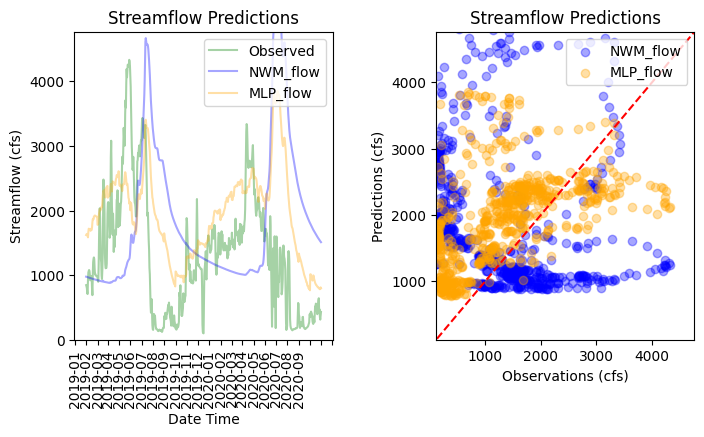

USGS site: 10134500


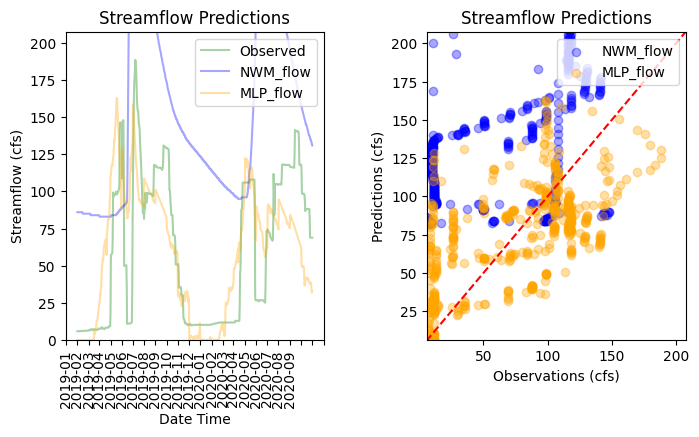

USGS site: 10136500


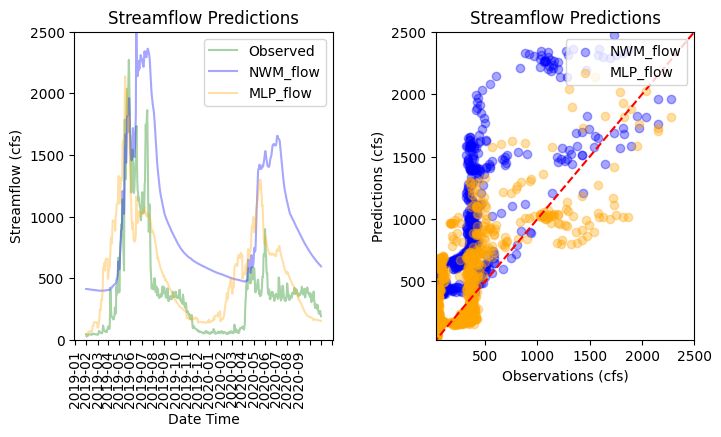

USGS site: 10140700


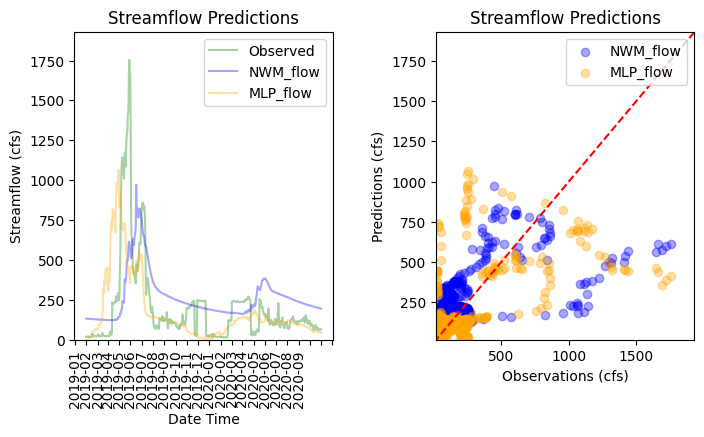

USGS site: 10141000


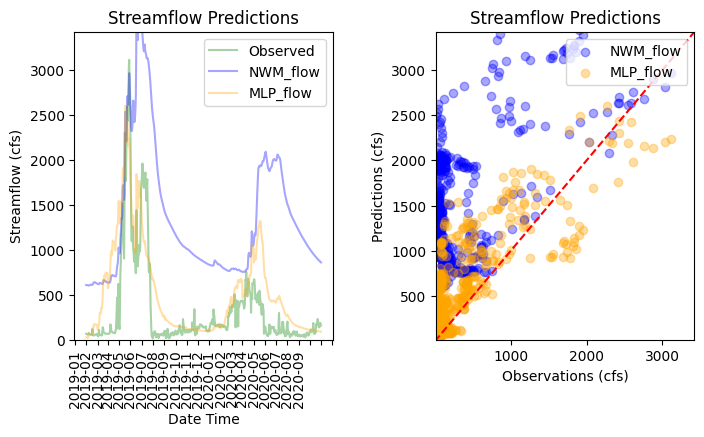

USGS site: 10155200


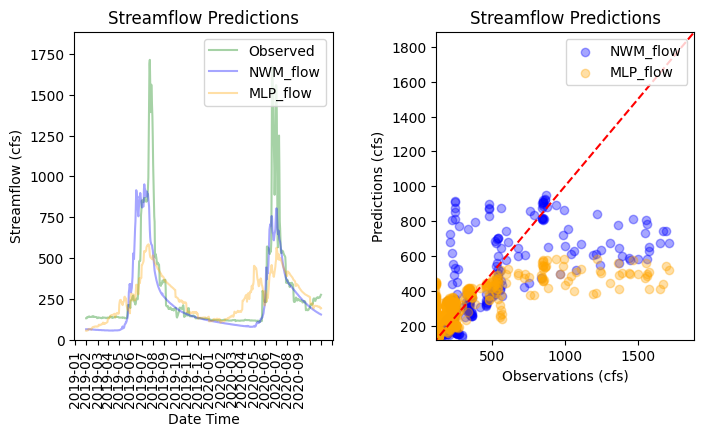

,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias
station_id,,,,,,,,
10134500,-0.97,0.69,132.0,35.0,545.15,113.70,-173.33,1.31
10136500,-0.42,0.52,644.0,335.0,330.76,149.41,-137.08,-40.68
10140700,0.29,0.46,236.0,239.0,221.61,124.57,-30.30,13.16
10141000,-2.10,0.41,1169.0,377.0,1111.22,226.45,-304.72,-55.70
10155200,0.63,0.36,192.0,229.0,29.28,41.22,15.23,10.18
10126000,-0.31,0.26,1716.0,1058.0,306.30,181.61,-39.65,-46.11


In [14]:
Eval_DF, Preds_Dict = mlp_model.Final_Model(GS_Eval_DF,
                x_train_scaled_t,
                y_train_scaled_t, 
                loss_func, 
                model_path, 
                modelname,
                test_years, 
                stations, 
                x_test_temp,
                x_test_scaled, 
                y_test_temp,
                StreamStats,
                station_index_list)
Eval_DF

## Code to manually train a model

In [ ]:
#Train the model with optimized parameters
# parameters
epochs = 75 # - seems to converge around 80 epochs with 100 batrch size
batch_size = 100
learning_rate = 0.0001  #look up learning rate scheduler https://www.geeksforgeeks.org/understanding-pytorch-learning-rate-scheduling/ -  smaller learning rates doing better!
decay = 0.0005
L1 = 128
L2 = 128
L3 = 64
L4 = 64
L5 = 32
L6 = 16
layers = x_train_scaled_t.shape[1], L1, L2, L3, L4, L5, L6
params =  learning_rate, decay, epochs, batch_size
loss_func = nn.MSELoss()

#Train the model
mlp_model.mlp_train(x_train_scaled_t,
                    y_train_scaled_t, 
                    layers, params, 
                    loss_func, 
                    model_path, 
                    modelname, 
                    shuffle = True)


#Make a prediction for each location, save as compressed pkl file, and send predictions to AWS for use in CSES
Preds_Dict = mlp_model.mlp_predict(test_years, 
                      layers, 
                      model_path, 
                      modelname, 
                      stations, 
                      x_test_temp,
                      x_test_scaled, 
                      y_test_temp,
                      StreamStats,
                      station_index_list)

#Evaluate model performance of the different models, 'flow_cfs_pred', 
prediction_columns = ['NWM_flow', f"{modelname}_flow"]
Eval_DF = Simple_Eval.Simple_Eval(Preds_Dict, 
                                  prediction_columns, 
                                  modelname, 
                                  supply = False,
                                  plots = False, 
                                  keystats = False        
                                  )
Eval_DF

